## Contents
1. Import Libraries and Set Directory
2. Data Cleaning
    * Functions
    * Total Demand
    * Temperature
    * Forecast Demand
    * Energy Prices and Demand
    * BOM
    * Solar Installations
    * Merge Datasets
3. Exploratory Data Analysis
    * Total Demand Timeseries
    * Temperature Timeseries
    * Rain Timeseries
    * Timeseries Comparison
    * Timeseries Comparison with Kernal Smoothing

In [158]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import zipfile
import tempfile # for temporary file storage to avoid storing large datasets on github
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar in for for-loops

In [159]:
base_dir = os.path.dirname(os.path.abspath("../data"))
path = os.path.join(base_dir, r"data")
os.chdir(path)

In [160]:
# os.listdir()

## Data Cleaning

#### Functions

In [161]:
# read zips from repo, extract data into temp dir, create dataframes
def zip_to_df(file_name):
    # create temporary directory  
    with tempfile.TemporaryDirectory() as tmpdirname:
        # collect data from zip file 
        with zipfile.ZipFile(file_name+".zip") as zip_file:
            file_list = zip_file.namelist()
            for file in file_list:
                zip_file.extract(file, tmpdirname)
            file_path = tmpdirname+"/"+ file_name
            # create and return dataframe
            df = pd.read_csv(file_path)
            return df

In [162]:
def create_date_vars(df, col, day_req=True):
    df["DATE"] = df[col].dt.date
    df["YEAR"] = df[col].dt.year
    df["MONTH"] = df[col].dt.month
    if day_req == True: df["DAY"] = df[col].dt.day
#     df["TIME"] = df[col].dt.time
#     df["HOURS"] = df[col].dt.hour
#     df["MINUTES"] = df[col].dt.minute
    return df

#### Total Demand

In [163]:
file_name = "totaldemand_nsw.csv"
totalDemand = zip_to_df(file_name)
print("Rows:", len(totalDemand))

Rows: 1323398


In [164]:
#update datatypes
totalDemand['DATETIME'] = pd.to_datetime(totalDemand['DATETIME'])

In [165]:
# create new date variables
totalDemand = create_date_vars(totalDemand, "DATETIME")

In [166]:
# remove redundant columns
totalDemand = totalDemand.drop(columns=["REGIONID"], errors='ignore')

In [167]:
# aggregate on date
totalDemandAgg = totalDemand.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
totalDemandAgg = totalDemandAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(totalDemandAgg))
totalDemandAgg.head()

Rows: 4596


,YEAR,MONTH,DAY,TOTALDEMAND
0,2010,1,1,7793.463681
1,2010,1,2,8012.314097
2,2010,1,3,7393.354514
3,2010,1,4,8254.502222
4,2010,1,5,8832.004931


#### Temperature

In [168]:
file_name = "temperature_nsw.csv"
temperature = zip_to_df(file_name)
print("Rows:", len(temperature))

Rows: 247646


In [169]:
#update datatypes
temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])

In [170]:
# create new date variables
temperature = create_date_vars(temperature, "DATETIME")

In [171]:
# remove redundant columns
temperature = temperature.drop(columns=["LOCATION"], errors='ignore')

In [172]:
# aggregate on date
temperatureAgg = temperature.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
temperatureAgg = temperatureAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(temperatureAgg))
temperatureAgg.head()

Rows: 4593


,YEAR,MONTH,DAY,TEMPERATURE
0,2010,1,1,25.094000
1,2010,1,2,24.765385
2,2010,1,3,19.429825
3,2010,1,4,20.625926
4,2010,1,5,22.660417


#### Forecast Demand

In [173]:
file_name = "forecastdemand_nsw.csv"
forecastDemand = zip_to_df(file_name)
print("Rows:", len(forecastDemand))

Rows: 11619503


In [174]:
#update datatypes
forecastDemand['DATETIME'] = pd.to_datetime(forecastDemand['DATETIME'])
forecastDemand['LASTCHANGED'] = pd.to_datetime(forecastDemand['LASTCHANGED'])

In [175]:
# create new date variables
forecastDemand = create_date_vars(forecastDemand, "DATETIME")

In [176]:
# remove redundant columns
forecastDemand = forecastDemand.drop(columns=["REGIONID","LASTCHANGED","PREDISPATCHSEQNO","PERIODID"], errors='ignore')

In [177]:
# aggregate
forecastDemandAgg = forecastDemand.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
forecastDemandAgg = forecastDemandAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(forecastDemandAgg))
forecastDemandAgg.head()

Rows: 4560


,YEAR,MONTH,DAY,FORECASTDEMAND
0,2010,1,1,7747.906211
1,2010,1,2,7773.818583
2,2010,1,3,7462.384786
3,2010,1,4,8467.411400
4,2010,1,5,8784.750420


#### Energy Prices and Demand

In [178]:
#merge all files in folder
wd = path + r"/Price and Demand - 2010-22"
files = os.listdir(wd)
prices = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(wd + "/" + file)
        prices = prices.append(file_df, ignore_index=True)
        file_count += 1
print("Merged", file_count, "files")

Merged 153 files


In [179]:
#remove additional headers
prices = prices[prices["REGION"]!="REGION"]
print("Rows:", len(prices))

Rows: 337488


In [180]:
#update datatypes
prices['SETTLEMENTDATE'] = pd.to_datetime(prices['SETTLEMENTDATE'])
prices['TOTALDEMAND'] = prices['TOTALDEMAND'].astype(float)
prices['RRP'] = prices['RRP'].astype(float)

In [181]:
# create new date variables
prices = create_date_vars(prices, "SETTLEMENTDATE")

In [182]:
# remove redundant columns
prices = prices.drop(columns=["REGION","PERIODTYPE"], errors='ignore')

In [183]:
# aggregate
pricesAgg = prices.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
pricesAgg = pricesAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(pricesAgg))
pricesAgg.head()

Rows: 4627


,YEAR,MONTH,DAY,TOTALDEMAND,RRP
0,2010,1,1,7796.317872,20.364894
1,2010,1,2,8017.459792,20.478125
2,2010,1,3,7399.899583,20.277083
3,2010,1,4,8241.720208,21.494583
4,2010,1,5,8827.813125,23.966042


#### BOM

In [184]:
# timeframe restriction
year_start = 2010

In [185]:
file_path = path + r"/Solar Exposure - Bankstown Airport/IDCJAC0016_066137_1800_Data.csv"
bomSolar = pd.read_csv(file_path)
bomSolar = bomSolar[bomSolar.Year >= year_start]
print("Rows:", len(bomSolar))

Rows: 4816


In [186]:
file_path = path + r"/Temperature - Bankstown Airport/IDCJAC0010_066137_1800_Data.csv"
bomTemp = pd.read_csv(file_path)
bomTemp = bomTemp[bomTemp.Year >= year_start]
print("Rows:", len(bomTemp))

Rows: 4816


In [187]:
file_path = path + r"/Rainfall - Bankstown/IDCJAC0009_066137_1800_Data.csv"
bomRain = pd.read_csv(file_path)
bomRain = bomRain[bomRain.Year >= year_start]
print("Rows:", len(bomRain))

Rows: 4817


In [188]:
# remove redundant columns
bomSolar = bomSolar.drop(columns=["Product code","Bureau of Meteorology station number"], errors='ignore')
bomTemp = bomTemp.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')
bomRain = bomRain.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')

In [189]:
# merge bom datasets and rename headers
bom = bomTemp.merge(bomRain, how="left", on=["Year","Month","Day"])
bom = bom.merge(bomSolar, how="outer", on=["Year","Month","Day"])
bom.columns = ['YEAR','MONTH','DAY','MAX','ACCMAX','RAIN','RAINPERIOD','SOLAR']
print("Rows:", len(bom))
bom.head()

Rows: 4816


,YEAR,MONTH,DAY,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR
0,2010,1,1,29.6,1.0,0.2,1.0,14.6
1,2010,1,2,29.5,1.0,0.0,1.0,18.4
2,2010,1,3,21.0,1.0,15.2,1.0,7.3
3,2010,1,4,24.0,1.0,0.2,1.0,14.4
4,2010,1,5,30.4,1.0,0.0,1.0,28.1


#### Solar Panels

In [190]:
#merge all files in folder
wd = path + r"/Solar Panel Installations - Bankstown"
files = os.listdir(wd)
sguSolar = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        sgu = pd.read_csv(wd + "/" + file)
        sgu = sgu[sgu["Small Unit Installation Postcode"]==2200]
        sgu = pd.melt(sgu, id_vars='Small Unit Installation Postcode')
        sgu = sgu[~sgu["variable"].str.contains("Previous Years")]
        sgu = sgu[~sgu["variable"].str.contains("Total")]
        sgu["Col"] = np.where(sgu["variable"].str.contains("Quantity"), "Quantity", "Output")
        sgu["variable"] = sgu["variable"].str.split('-').str[0]
        sgu["value"] = sgu["value"].astype(float)
        sgu = pd.pivot_table(sgu, values="value", columns="Col", index=["Small Unit Installation Postcode", "variable"]).reset_index()
        sguSolar = sguSolar.append(sgu, ignore_index=True, sort=False)
        file_count += 1
print("Merged", file_count, "files")
print("Rows:", len(sguSolar))

Merged 12 files
Rows: 278


In [191]:
# update datatypes
sguSolar["DATETIME"] = pd.to_datetime(sguSolar["variable"])

In [192]:
# remove redundant columns
sguSolar = sguSolar.drop(columns=["Small Unit Installation Postcode","variable"], errors='ignore')

In [193]:
# rename columns
sguSolar.columns = ["OUTPUT","QUANTITY","DATETIME"]

In [194]:
# create new date variables
sguSolar = create_date_vars(sguSolar, "DATETIME", day_req=False)

In [195]:
# calculate cumulative sum, ordered by date
sguSolar = sguSolar.sort_values(['DATE'], ascending=[True])
sguSolar["QUANTITYMONTHCUM"] = sguSolar.groupby(['DATE'])['QUANTITY'].cumsum(axis=0)
sguSolar["QUANTITYTOTALCUM"] = sguSolar['QUANTITY'].cumsum(axis=0)
sguSolar["OUTPUTMONTHCUM"] = sguSolar.groupby(['DATE'])['OUTPUT'].cumsum(axis=0)
sguSolar["OUTPUTTOTAL"] = sguSolar['OUTPUT'].cumsum(axis=0)
sguSolar = sguSolar.drop(columns=["DATETIME","DATE"], errors='ignore')
print("Rows:", len(sguSolar))
sguSolar.head()

Rows: 278


,OUTPUT,QUANTITY,YEAR,MONTH,QUANTITYMONTHCUM,QUANTITYTOTALCUM,OUTPUTMONTHCUM,OUTPUTTOTAL
80,0.00,0.0,2009,1,0.0,0.0,0.00,0.00
78,0.00,0.0,2009,2,0.0,0.0,0.00,0.00
86,0.00,0.0,2009,3,0.0,0.0,0.00,0.00
72,0.99,1.0,2009,4,1.0,1.0,0.99,0.99
88,1.00,1.0,2009,5,1.0,2.0,1.00,1.99


#### Merge All Datasets

In [196]:
df = totalDemandAgg.merge(bom, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(pricesAgg, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(forecastDemandAgg, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(sguSolar, how="left", on=["YEAR","MONTH"])
print("Rows:", len(df))
df.head() 

Rows: 8248


,YEAR,MONTH,DAY,TOTALDEMAND_x,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR,TOTALDEMAND_y,RRP,FORECASTDEMAND,OUTPUT,QUANTITY,QUANTITYMONTHCUM,QUANTITYTOTALCUM,OUTPUTMONTHCUM,OUTPUTTOTAL
0,2010,1,1,7793.463681,29.6,1.0,0.2,1.0,14.6,7796.317872,20.364894,7747.906211,1.53,1.0,1.0,20.0,1.53,31.86
1,2010,1,1,7793.463681,29.6,1.0,0.2,1.0,14.6,7796.317872,20.364894,7747.906211,1.53,1.0,2.0,21.0,3.06,33.39
2,2010,1,2,8012.314097,29.5,1.0,0.0,1.0,18.4,8017.459792,20.478125,7773.818583,1.53,1.0,1.0,20.0,1.53,31.86
3,2010,1,2,8012.314097,29.5,1.0,0.0,1.0,18.4,8017.459792,20.478125,7773.818583,1.53,1.0,2.0,21.0,3.06,33.39
4,2010,1,3,7393.354514,21.0,1.0,15.2,1.0,7.3,7399.899583,20.277083,7462.384786,1.53,1.0,1.0,20.0,1.53,31.86


## Exploratory Data Analysis

In [197]:
df.describe()

,YEAR,MONTH,DAY,TOTALDEMAND_x,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR,TOTALDEMAND_y,RRP,FORECASTDEMAND,OUTPUT,QUANTITY,QUANTITYMONTHCUM,QUANTITYTOTALCUM,OUTPUTMONTHCUM,OUTPUTTOTAL
count,8248.000000,8248.000000,8248.000000,8248.000000,8208.000000,8208.0,8066.000000,8064.0,8246.000000,8248.000000,8248.000000,8183.000000,7883.000000,7883.000000,7883.000000,7883.000000,7883.00000,7883.000000
mean,2015.225145,6.459020,15.725267,8111.543731,24.125938,1.0,2.470146,1.0,15.839389,8111.602001,62.068918,8066.977269,67.453317,11.239376,16.232145,1643.883293,94.35112,5963.717967
std,3.382902,3.442087,8.800412,804.685607,5.493147,0.0,8.747097,0.0,7.321437,803.284454,64.504773,804.693001,73.940852,10.164189,16.603299,742.800165,105.78448,4345.226290
min,2010.000000,1.000000,1.000000,5970.921181,9.600000,1.0,0.000000,1.0,1.000000,5970.921181,14.362222,5518.989111,0.000000,0.000000,0.000000,20.000000,0.00000,31.860000
25%,2012.000000,3.000000,8.000000,7555.606623,19.700000,1.0,0.000000,1.0,10.500000,7556.311354,32.871667,7497.938463,24.480000,6.000000,7.000000,1227.000000,31.53000,2480.444000
50%,2015.000000,6.000000,16.000000,8056.711771,23.700000,1.0,0.000000,1.0,14.600000,8059.885208,50.562813,8026.797902,41.160000,9.000000,12.000000,1765.000000,59.84000,5346.394000
75%,2018.000000,9.000000,23.000000,8655.697066,27.800000,1.0,0.400000,1.0,21.000000,8652.875625,73.981719,8627.338480,79.570000,13.000000,20.000000,2199.000000,123.01000,8733.823000
max,2022.000000,12.000000,31.000000,11537.208785,47.000000,1.0,159.600000,1.0,34.200000,11539.817500,1539.430000,11234.220537,458.355000,73.000000,146.000000,2950.000000,916.71000,17669.789000


In [199]:
df.to_excel(r'../Data/Final_data.xlsx', index=False)

### Testing / Working

In [142]:
df_lim = df[df["YEAR"]>2020]

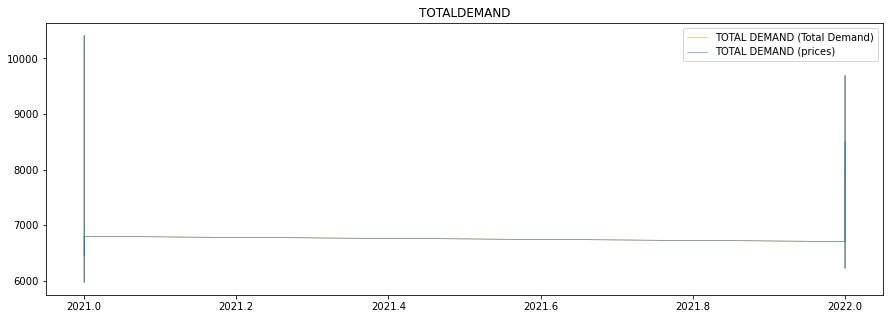

In [143]:
 # Total Demand
 #df2 = df.iloc[:, 0]
 x = df_lim.iloc[:, 0]
 y1 = df_lim.TOTALDEMAND_x
 y2 = df_lim.TOTALDEMAND_y

 fig, ax = plt.subplots(figsize=(15,5))

 ax.plot(x, y1, linewidth=0.5, label='TOTAL DEMAND (Total Demand)', color="orange")
 ax.plot(x, y2, linewidth=0.5, label='TOTAL DEMAND (prices)')

 ax.set_title("TOTALDEMAND")
 handles, labels = ax.get_legend_handles_labels()
 ax.legend(handles, labels)

 plt.show() 

In [124]:
# set variables
x = df_lim.day
yTemp = df_lim.MAX
yDemand = df_lim.TOTALDEMAND_x
yRain = df_lim.RAIN
ySolar = df_lim.SOLAR

AttributeError: 'DataFrame' object has no attribute 'day'

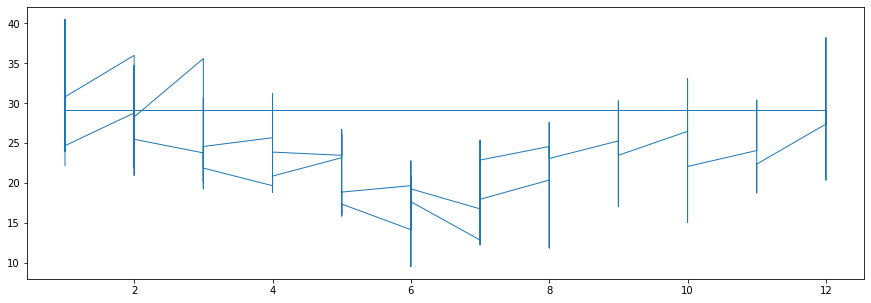

In [122]:
# Temperature
plt.figure(figsize=(15,5))
plt.plot(x, yTemp, linewidth=1)
plt.show() 

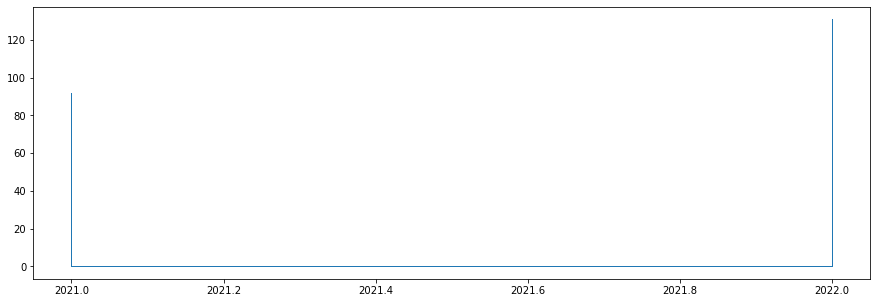

In [112]:
# Rain
plt.figure(figsize=(15,5))
plt.plot(x, yRain, linewidth=1)
plt.show() 

In [113]:
# # compare all variables
# fig, ax1 = plt.subplots(figsize=(15,5))
# ax2 = ax1.twinx()
# ax3 = ax1.twinx()
# ax1.plot(x, yDemand, linewidth=0.1, label='TOTALDEMAND', color="purple")
# ax2.plot(x, yTemp, linewidth=1, label='TEMP', color="orange")
# ax3.bar(x, yRain, linewidth=1, label='RAIN')
# plt.show() 

In [114]:
# compare all variables, but apply kernal smoothing on demand and temp
yTempSeries = pd.Series(yTemp)
yTempSmooth = yTempSeries.rolling(window=15, win_type='gaussian', center=True).mean(std=0.5)
yDemandSeries = pd.Series(yDemand)
yDemandSmooth = yDemandSeries.rolling(window=50, win_type='gaussian', center=True).mean(std=0.5)

In [115]:
dfCopy = df.copy()
dfCopy["MAXSMOOTH"] = yTempSmooth
dfCopy["TOTALDEMANDSMOOTH"] = yDemandSmooth
dfCopy.head()

,YEAR,MONTH,DAY,TOTALDEMAND_x,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR,TOTALDEMAND_y,RRP,FORECASTDEMAND,OUTPUT,QUANTITY,QUANTITYMONTHCUM,QUANTITYTOTALCUM,MAXSMOOTH,TOTALDEMANDSMOOTH
0,2010,1,1,7793.463681,29.6,1.0,0.2,1.0,14.6,7796.317872,20.364894,7747.906211,1.53,1.0,1.0,20.0,NaN,NaN
1,2010,1,1,7793.463681,29.6,1.0,0.2,1.0,14.6,7796.317872,20.364894,7747.906211,1.53,1.0,2.0,21.0,NaN,NaN
2,2010,1,2,8012.314097,29.5,1.0,0.0,1.0,18.4,8017.459792,20.478125,7773.818583,1.53,1.0,1.0,20.0,NaN,NaN
3,2010,1,2,8012.314097,29.5,1.0,0.0,1.0,18.4,8017.459792,20.478125,7773.818583,1.53,1.0,2.0,21.0,NaN,NaN
4,2010,1,3,7393.354514,21.0,1.0,15.2,1.0,7.3,7399.899583,20.277083,7462.384786,1.53,1.0,1.0,20.0,NaN,NaN


In [116]:
# compare all variables
x = dfCopy.DATETIME
y = dfCopy.TOTALDEMANDSMOOTH
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(x, y, linewidth=0.1, label='TOTALDEMAND', color="purple")
plt.show() 

AttributeError: 'DataFrame' object has no attribute 'DATETIME'